In [403]:
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
from tqdm import tqdm 

In [404]:
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

In [405]:
param_name = "Theta_7"



In [407]:
np.sum([len(PHI[i]) for i in range(n)])

16522

In [425]:


# load parameters
with open(f'/home/chri6578/Documents/CES/params/{param_name}.pickle', 'rb') as file:
    Theta = pickle.load(file)

n = Theta['n']
Lambda = Theta['Lambda']
Gamma = Theta['Gamma']

bar_tau_0 = 20
tau_bar = 20


def gen_sequence_simple(n, Lambda, Gamma, T, bar_tau_0):
    
    n = n 
    Lambda = Lambda 
    Gamma = Gamma
    
    # step 2
    PHI = {}

    for i in range(n):
        PHI[i] = []
        t = 0
        t_prev = 0
        while t_prev < T:
            t = np.random.exponential(Lambda[i])[0]
            PHI[i].append(t + t_prev)
            t_prev = t + t_prev

    # step 3
    tuple_list = [(i, t) for i in range(n) for t in PHI[i]]
    T_list = sorted(tuple_list, key=lambda x: x[1])

    # steps 4-11

    E_all = {}
    for i in range(n):
        E_all[i] = []
    t_last = np.zeros((n,))

    for (e,t) in T_list:
        
        s = np.sum( Gamma[e]*(t_last != 0)*(t_last < t)*(t_last > t - bar_tau_0) )
        p = sigmoid(s)
        trial = p >= 0.5
        
        # update x_i^t
        if trial:
            E_all[e].append(t)
            t_last[e] = t
            
    return (PHI, E_all)



In [ ]:


def estimate(PHI, E_all, tau_bar, n):
    
    pow2 = np.power(2, np.arange(n))

    Y0 = np.zeros((n, 2**n))
    Y1 = np.zeros((n, 2**n))

    for i in tqdm(range(n)):
        for t in PHI[i]:
            z = np.zeros((n,))
            for j in range(n):
                z[j] = np.sum((E_all[j] > t - tau_bar)*(E_all[j] < t)) > 0
                
            if t in E_all[i]:
                Y1[i][int(z.T @ pow2)] +=1
            else:
                Y0[i][int(z.T @ pow2)] +=1
                
    Y_sum = Y0 + Y1 

    P1 = Y1 / Y_sum

    # check impact of j on i
    A_est = np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            effect = []
            for k in range(2**n):
                if k & (1 << j) == 0:
                    # j is present
                    effect.append(P1[i][k+pow2[j]]- P1[i][k])
            if np.isnan(np.nanmean(effect)) == 0:
                A_est[i][j] = np.nanmean(effect)
                
    return A_est 

PHI, E_all = gen_sequence_simple(param_name, 1e4, bar_tau_0)
A_est = estimate(PHI, E_all, tau_bar, n)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:03<00:00,  2.92it/s]
/tmp/ipykernel_112310/713905159.py:21: RuntimeWarning: invalid value encountered in divide
  P1 = Y1 / Y_sum


Text(0.5, 1.0, '$ A (true) $')

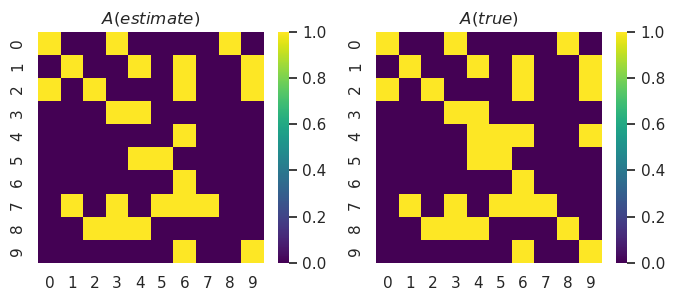

In [413]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot each heatmap
sns.heatmap(np.abs(A_est) > 0 , ax=axes[0], cmap="viridis", vmin=0, vmax=1)
axes[0].set_title("$ A (estimate) $")

sns.heatmap(Alpha > 0 , ax=axes[1], cmap="viridis", vmin=0, vmax=1)
axes[1].set_title("$ A (true) $")



In [414]:
accuracy = 1 - np.sum(np.abs(np.double(np.abs(A_est) > 0 ) - np.double( Alpha > 0 )))/(n*n)

0.96

In [415]:
T/(2**n)

9.765625

Text(0.5, 1.0, 'gamma ')

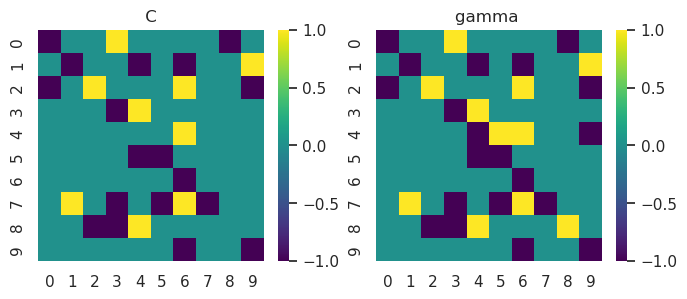

In [416]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot each heatmap
sns.heatmap(np.sign(A_est) , ax=axes[0], cmap="viridis")
axes[0].set_title(" C ")

sns.heatmap(np.sign(Gamma) , ax=axes[1], cmap="viridis")
axes[1].set_title("gamma ")

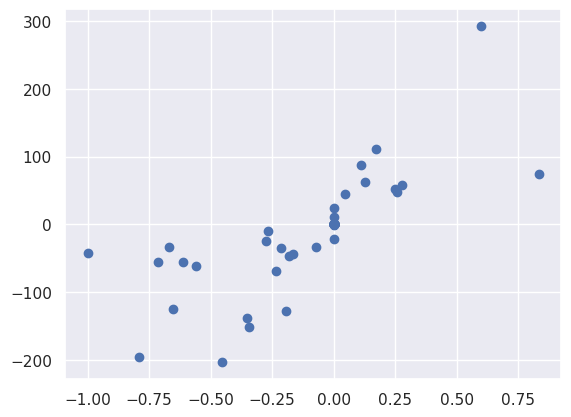

In [417]:
plt.scatter(A_est, Gamma)

In [421]:
W = np.sign(A_est)*np.sign(Gamma)
sign_accuracy = np.sum(W == 1)/np.sum(A_est != 0) # how correctly the causal signs are deciphered

1.0